In [42]:
import os
import sys
import arxiv

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain import hub

from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_openai import ChatOpenAI

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field


from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import END, StateGraph


from typing_extensions import TypedDict
from typing import List

from dotenv import load_dotenv
load_dotenv()

True

In [43]:
PAPERS = ['2205.14135', '2005.14165', '1706.03762', '2403.14403', '2310.11511', '2401.15884']

In [44]:
os.makedirs('./papers', exist_ok=True)
client = arxiv.Client()
papers = client.results(arxiv.Search(id_list=PAPERS))
for paper in papers:
    print(paper.title)
    paper.download_pdf(dirpath="./papers", filename="{}.pdf".format(paper.title.replace(' ','')))


FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness
Language Models are Few-Shot Learners
Attention Is All You Need
Adaptive-RAG: Learning to Adapt Retrieval-Augmented Large Language Models through Question Complexity
Self-RAG: Learning to Retrieve, Generate, and Critique through Self-Reflection
Corrective Retrieval Augmented Generation


In [45]:
docs = []

for dirpath, dirnames, filenames in os.walk('./papers/'):
    for file in filenames:
        file_path = os.path.join(dirpath, file)
        docs += PyPDFLoader(file_path).load()

In [46]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs)

In [47]:
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

In [48]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

# LLM with function call 
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt 
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
    
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "flash attention"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(doc_txt)
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

optimal for a range of SRAM sizes. We also extend FlashAttention to block-sparse attention, yielding
an approximate attention algorithm that is faster than any existing approximate attention method.
FlashAttention trains Transformers faster than existing baselines: 15% end-to-end wall-clock speedup
on BERT-large (seq. length 512) compared to the MLPerf 1.1 training speed record, 3 speedup on
GPT-2 (seq. length 1K), and 2.4 speedup on long-range arena (seq. length 1K-4K). FlashAttention
and block-sparse FlashAttention enable longer context in Transformers, yielding higher quality models
(0.7 better perplexity on GPT-2 and 6.4 points of lift on long-document classiﬁcation) and entirely new
capabilities: the ﬁrst Transformers to achieve better-than-chance performance on the Path-X challenge
(seq. length 16K, 61.4% accuracy) and Path-256 (seq. length 64K, 63.1% accuracy).
1 Introduction
Transformer models [ 82] have emerged as the most widely used architecture in applications such as nat

In [49]:
# Prompt
prompt = hub.pull("rlm/rag-prompt")
prompt

ChatPromptTemplate(input_variables=['context', 'question'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])

In [50]:
# LLM
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

FlashAttention is a fast and memory-efficient exact attention algorithm that trains Transformers faster than existing baselines. It enables longer context in Transformers, resulting in higher quality models and new capabilities. FlashAttention is up to 3 times faster than standard attention implementations and scales up to 64K sequence lengths.


In [51]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(description="Answer is grounded in the facts, 'yes' or 'no'")

# LLM with function call 
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt 
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [52]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(description="Answer addresses the question, 'yes' or 'no'")

# LLM with function call 
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt 
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question,"generation": generation})

GradeAnswer(binary_score='yes')

In [53]:
web_search_tool = TavilySearchResults(k=3)

In [54]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents 
    """
    question : str
    generation : str
    web_search : bool
    grounded : bool
    documents : List[str]
    steps : int
    end : bool

In [55]:
def retrieve(state: GraphState) -> GraphState:
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print('-- RETRIEVE --')
    question = state['question']
    docs = retriever.invoke(question)

    return {
        'documents' : docs,
        'question' : question
    }
    

In [56]:
def generate(state: GraphState) -> GraphState:
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state['question']
    docs = state['documents']
    generation = rag_chain.invoke({"context": docs, "question": question})

    return {
        'documents' : docs,
        'question' : question,
        'generation': generation
    }

In [57]:
def grade_documents(state: GraphState) -> GraphState:
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state['question']
    docs = state['documents']
    new_docs = []
    web_search = False
    for doc in docs:
        res = retrieval_grader.invoke({"question": question, "document": doc})
        score = res.binary_score
        
        if score.lower() == 'yes':
            print("---GRADE: DOCUMENT RELEVANT---")
            new_docs.append(doc)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = True
    
    return {
        'documents' : new_docs,
        'question' : question,
        'web_search' : web_search
    }


In [58]:
def web_search(state: GraphState) -> GraphState:
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {
        "documents": documents,
        "question": question
    }


In [59]:
def decide_to_generate(state: GraphState) -> str:
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]

    if web_search:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [60]:
def grade_generation_v_documents(state: GraphState) -> GraphState:
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended hallucination addressing measure
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    docs = state['documents']
    generation = state["generation"]
    steps = state["steps"]
    score = hallucination_grader.invoke({"documents": docs, "generation": generation})
    grade = score.binary_score
    
    grounded = grade.lower() == 'yes'
    if grounded:
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
    else:
        print("---DECISION: REGENERATE---")
        if steps is not None:
            steps += 1
        else:
            steps = 1
        
        
    
    return {
        "question" : question,
        "generation" : generation,
        "grounded" : grounded,
        "steps" : steps,
        "documents" : docs
    }

In [61]:
def grade_generation_v_question(state: GraphState) -> GraphState:
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended question addressing measure
    """

    print("---CHECK GENERATON ADDRESSES QUESTION---")
    question = state["question"]
    docs = state['documents']
    generation = state["generation"]
    steps = state["steps"]


    score = answer_grader.invoke({"question": question,"generation": generation})
    grade = score.binary_score

    end = False
    if grade.lower() == 'yes':
        print("---DECISION: GENERATION ADDRESSES QUESTION---")
        end = True
    else:
        print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        if steps is not None:
            steps += 1
        else:
            steps = 1
        
    
    return {
        "question" : question,
        "generation" : generation,
        "end" : end,
        "documents" : docs
    }

In [62]:
def hallucinated(state: GraphState) -> str:
    """
    Determines whether to regenerate an answer based on halluciation

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    
    grounded= state["grounded"]
    
    if grounded:
        return "yes"
    else:
        steps =   state["steps"]
        if steps < 5:
            return "regenerate"
        else:
            print("---EXCEEDED STEPS---")
        return "end"

In [63]:
def answers_question(state: GraphState) -> str:
    """
    Determines whether to regenerate an answer based on the quality of the answer

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    
    
    print("---ASSESS HALLUCINATIONS---")
    end = state["end"]
    
    if end:
        return "end"
    else:
        steps =   state["steps"]

        if steps < 5:
            return "regenerate"
        else:
            print("---EXCEEDED STEPS---")
        return "end"

In [64]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("check_hallucination", grade_generation_v_documents) #hallucination check
workflow.add_node("check_answer", grade_generation_v_question) #hallucination check


# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("generate", "check_hallucination")
workflow.add_conditional_edges(
    "check_hallucination",
    hallucinated,
    {
        "regenerate": "generate",
        "end": END,
        "yes": "check_answer",
    },
)
workflow.add_conditional_edges(
    "check_answer",
    answers_question,
    {
        "regenerate": "websearch",
        "end": END,
    },
)

# Compile
app = workflow.compile()

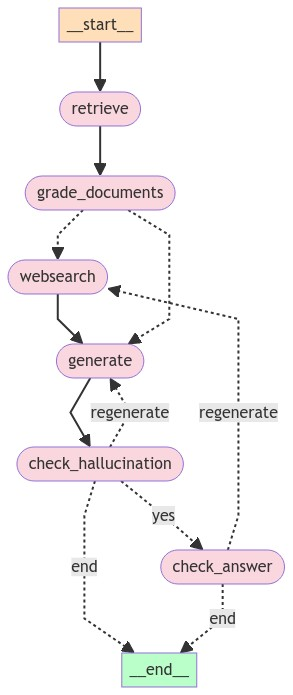

In [65]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeColors

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [66]:
inputs = {"question": "What matrixes are part of attention?"}
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Finished running: {key}:")
print(value["generation"])

-- RETRIEVE --
Finished running: retrieve:
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
Finished running: grade_documents:
---GENERATE---
Finished running: generate:
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
Finished running: check_hallucination:
---CHECK GENERATON ADDRESSES QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
---ASSESS HALLUCINATIONS---
Finished running: check_answer:
The attention matrix in FlashAttention is a function of a low-rank matrix QK. Structured matrices like Toeplitz-like, low-displacement rank, and quasi-separable matrices have been proposed in machine learning. The butterﬂy pattern used in block-sparse attention can express any structured matrices with optimal runtime and parameters.


In [67]:
inputs = {"question": "What is a decoder only architecture?"}
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Finished running: {key}:")
print(value["generation"])

-- RETRIEVE --
Finished running: retrieve:
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
Finished running: grade_documents:
---WEB SEARCH---
Finished running: websearch:
---GENERATE---
Finished running: generate:
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
Finished running: check_hallucination:
---CHECK GENERATON ADDRESSES QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
---ASSESS HALLUCINATIONS---
Finished running: check_answer:
A decoder-only architecture is a variant of the Transformer model that retains only the decoder component. It is particularly well-suited for autoregressive tasks, generating output tokens one by one based on previously generated tokens. This architecture does not have an explicit en

In [68]:
inputs = {"question": "Andrej Karpathy just released GPT-2 the movie where he used flash attention to optimize the training time. Who is Andrej Karpathy?"}
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Finished running: {key}:")
print(value["generation"])

-- RETRIEVE --
Finished running: retrieve:
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
Finished running: grade_documents:
---WEB SEARCH---
Finished running: websearch:
---GENERATE---
Finished running: generate:
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
Finished running: check_hallucination:
---CHECK GENERATON ADDRESSES QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
---ASSESS HALLUCINATIONS---
Finished running: check_answer:
Andrej Karpathy is a Slovak-Canadian computer scientist who has worked at Tesla and OpenAI. He has a background in convolutional/recurrent neural networks and their applications in computer vision and natural language processing. Karpathy has made significant contributions to